# Business Understanding

## Brief description
This is a dataset of AirBnB listings in Seattle. It has details about the prices, ratings, host information, amenities provided by the property etc. I am looking at the amenities provided and also see how they react with price and ratings
## Question 1
What are the popular amenities?
## Question 2
How do amenities influcnce the price of the listing?
## Question 3
How does amenities influence the rating of the listing?
## Question 4
Which amenities ususally come together?

# Data Understanding

## Access and Explore

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.linear_model import LinearRegression

In [4]:
df = pd.read_csv('data/listings.csv')

In [5]:
df.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


In [6]:
df['amenities'][0]

'{TV,"Cable TV",Internet,"Wireless Internet","Air Conditioning",Kitchen,Heating,"Family/Kid Friendly",Washer,Dryer}'

# Prepare Data

## Clean

### Reshape amenities

In [7]:
amenities = df['amenities'].str.replace(r'[{}""]', '', regex=True)
amenities = amenities.str.get_dummies(',')
amenities.head()

,24-Hour Check-in,Air Conditioning,Breakfast,Buzzer/Wireless Intercom,Cable TV,Carbon Monoxide Detector,Cat(s),Dog(s),Doorman,Dryer,...,Safety Card,Shampoo,Smoke Detector,Smoking Allowed,Suitable for Events,TV,Washer,Washer / Dryer,Wheelchair Accessible,Wireless Internet
0,0,1,0,0,1,0,0,0,0,1,...,0,0,0,0,0,1,1,0,0,1
1,0,0,0,1,0,1,0,0,0,1,...,1,0,1,0,0,1,1,0,0,1
2,0,1,0,0,1,1,1,1,0,1,...,0,1,1,0,0,1,1,0,0,1
3,0,0,0,0,0,1,0,0,0,1,...,1,1,1,0,0,0,1,0,0,1
4,0,0,0,0,1,1,0,0,0,0,...,0,1,1,0,0,1,0,0,0,1


### Clean price

In [8]:
df['price'] = df['price'].str.replace('[$,]', '', regex=True).astype(float)

### Combined related amenities

In [9]:
amenities_cleaned = amenities.copy()

In [10]:
combining = {
    'Internet*': ['Internet', 'Wireless Internet'],
    'Smoke Detector*': ['Smoke Detector', 'Carbon Monoxide Detector'],
    'TV*': ['TV', 'Cable TV'],
    'Pets':['Pets Allowed', 'Dog(s)', 'Cat(s)', 'Other pet(s)'],
    'Washer/Dryer*': ['Dryer', 'Washer', 'Washer / Dryer']
}

In [11]:
for combined_column, columns in combining.items():
    amenities_cleaned[combined_column] = 0
    for column in columns:
        amenities_cleaned[combined_column] = amenities_cleaned[combined_column] | amenities_cleaned[column]
    amenities_cleaned.drop(columns=columns, inplace=True)
amenities_cleaned.columns = [c.replace('*', '') for c in amenities_cleaned.columns]
amenities_cleaned.head()

,24-Hour Check-in,Air Conditioning,Breakfast,Buzzer/Wireless Intercom,Doorman,Elevator in Building,Essentials,Family/Kid Friendly,Fire Extinguisher,First Aid Kit,...,Safety Card,Shampoo,Smoking Allowed,Suitable for Events,Wheelchair Accessible,Internet,Smoke Detector,TV,Pets,Washer/Dryer
0,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,1,0,1
1,0,0,0,1,0,0,1,1,1,1,...,1,0,0,0,0,1,1,1,0,1
2,0,1,0,0,0,0,1,1,0,0,...,0,1,0,0,0,1,1,1,1,1
3,0,0,0,0,0,0,1,1,1,0,...,1,1,0,0,0,1,1,0,0,1
4,0,0,0,0,0,0,1,1,1,1,...,0,1,0,0,0,1,1,1,0,0


In [12]:
amenities_cleaned.shape

(3818, 33)

# Question 1: What are the popular amenities?

## Analyse

In [13]:
amenities_order = amenities_cleaned.sum().sort_values(ascending=False)
amenities_order

Internet                      3692
Heating                       3627
Kitchen                       3423
Smoke Detector                3291
Essentials                    3237
Washer/Dryer                  3022
TV                            2741
Shampoo                       2670
Fire Extinguisher             2196
Free Parking on Premises      2167
Family/Kid Friendly           1963
First Aid Kit                 1680
Pets                          1114
Indoor Fireplace               886
Pets live on this property     883
Hangers                        846
Elevator in Building           785
Hair Dryer                     774
Laptop Friendly Workspace      745
Iron                           742
Safety Card                    727
Air Conditioning               677
24-Hour Check-in               616
Buzzer/Wireless Intercom       538
Gym                            442
Hot Tub                        303
Wheelchair Accessible          300
Breakfast                      291
Suitable for Events 

## Visualise

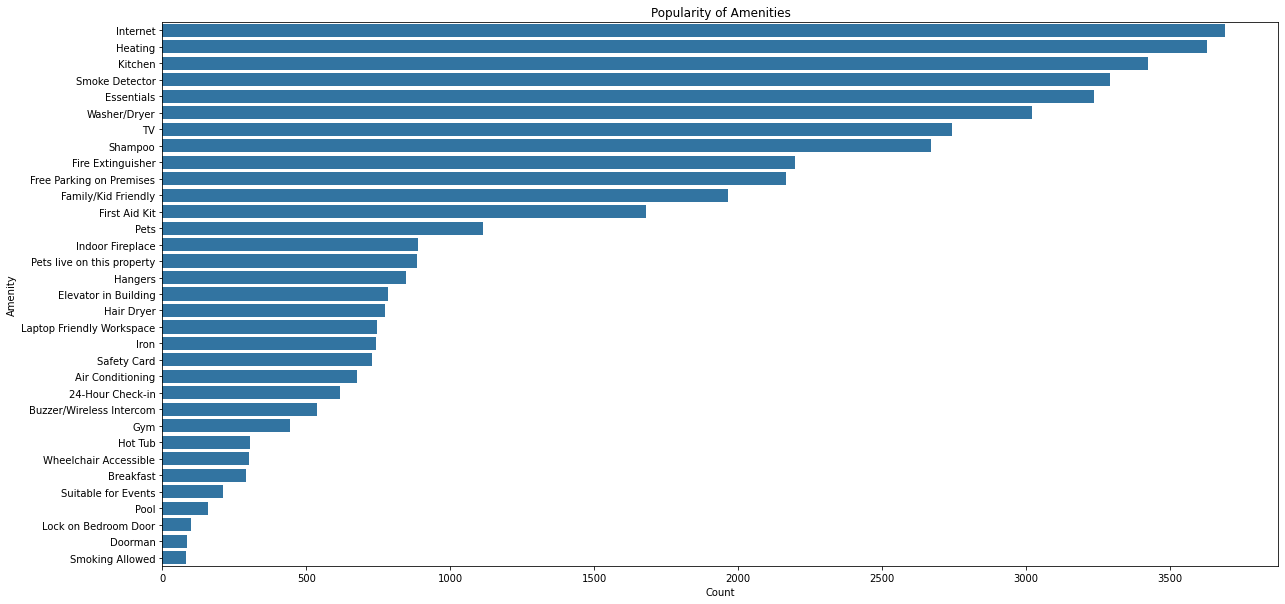

In [14]:
plt.figure(figsize=(20, 10))
base_color = sns.color_palette()[0]
sns.barplot(y=amenities_order.index, x=amenities_order.values, color=base_color);
plt.title('Popularity of Amenities')
plt.xlabel('Count')
plt.ylabel('Amenity');

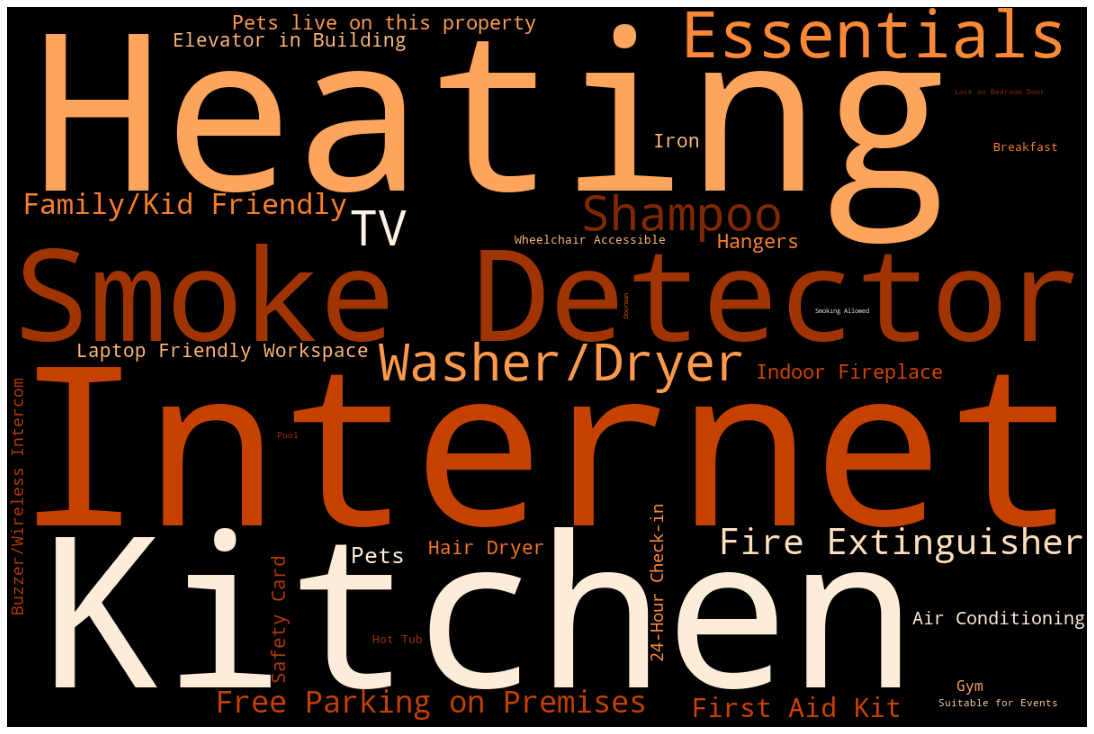

In [15]:
wc = WordCloud(height=800, width=1200, colormap='Oranges')
wc.generate_from_frequencies({k: v for [k, v] in amenities_order.reset_index().values})
plt.figure(figsize=(20, 10))
plt.imshow(wc)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

## Brief explanation for visualisation

Kitchen, Internet and Heating are the most common. Smoke detectors, Essentials, Blowers/Dryers and TV follow Internet, Heating and Kitchen. The least frequent ones are smoking allowed, doorman and bathroom doors. But I guess these are things that the hosts do not bother adding.  

# Question 2: How do amenities influcnce the price of the listing?

## Analyse

In [16]:
amenities_and_price = pd.concat([amenities_cleaned, df[['price']]], axis=1)
amenities_and_price.head()

,24-Hour Check-in,Air Conditioning,Breakfast,Buzzer/Wireless Intercom,Doorman,Elevator in Building,Essentials,Family/Kid Friendly,Fire Extinguisher,First Aid Kit,...,Shampoo,Smoking Allowed,Suitable for Events,Wheelchair Accessible,Internet,Smoke Detector,TV,Pets,Washer/Dryer,price
0,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,1,0,1,85.0
1,0,0,0,1,0,0,1,1,1,1,...,0,0,0,0,1,1,1,0,1,150.0
2,0,1,0,0,0,0,1,1,0,0,...,1,0,0,0,1,1,1,1,1,975.0
3,0,0,0,0,0,0,1,1,1,0,...,1,0,0,0,1,1,0,0,1,100.0
4,0,0,0,0,0,0,1,1,1,1,...,1,0,0,0,1,1,1,0,0,450.0


In [17]:
price_amenity_availability = amenities_and_price.melt(id_vars=['price'], var_name='amenity', value_name='available')
price_amenity_availability.head()
mean_price_amenity_availability = price_amenity_availability.groupby(['amenity', 'available']).mean()['price'].reset_index()
mean_price_amenity_availability.rename(columns={'price': 'mean_price'})
mean_price_amenity_availability.head()

,amenity,available,price
0,24-Hour Check-in,0,127.285134
1,24-Hour Check-in,1,131.568182
2,Air Conditioning,0,122.518625
3,Air Conditioning,1,153.296898
4,Breakfast,0,130.645024


In [18]:
X, y = amenities_cleaned, df['price']
linear_model = LinearRegression()
linear_model.fit(X, y)
amenities_coefs = pd.DataFrame({
    'amenity': X.columns,
    'coef': linear_model.coef_
})
amenities_coefs.sort_values('coef', inplace=True)

## Visualise

<AxesSubplot:xlabel='price', ylabel='amenity'>

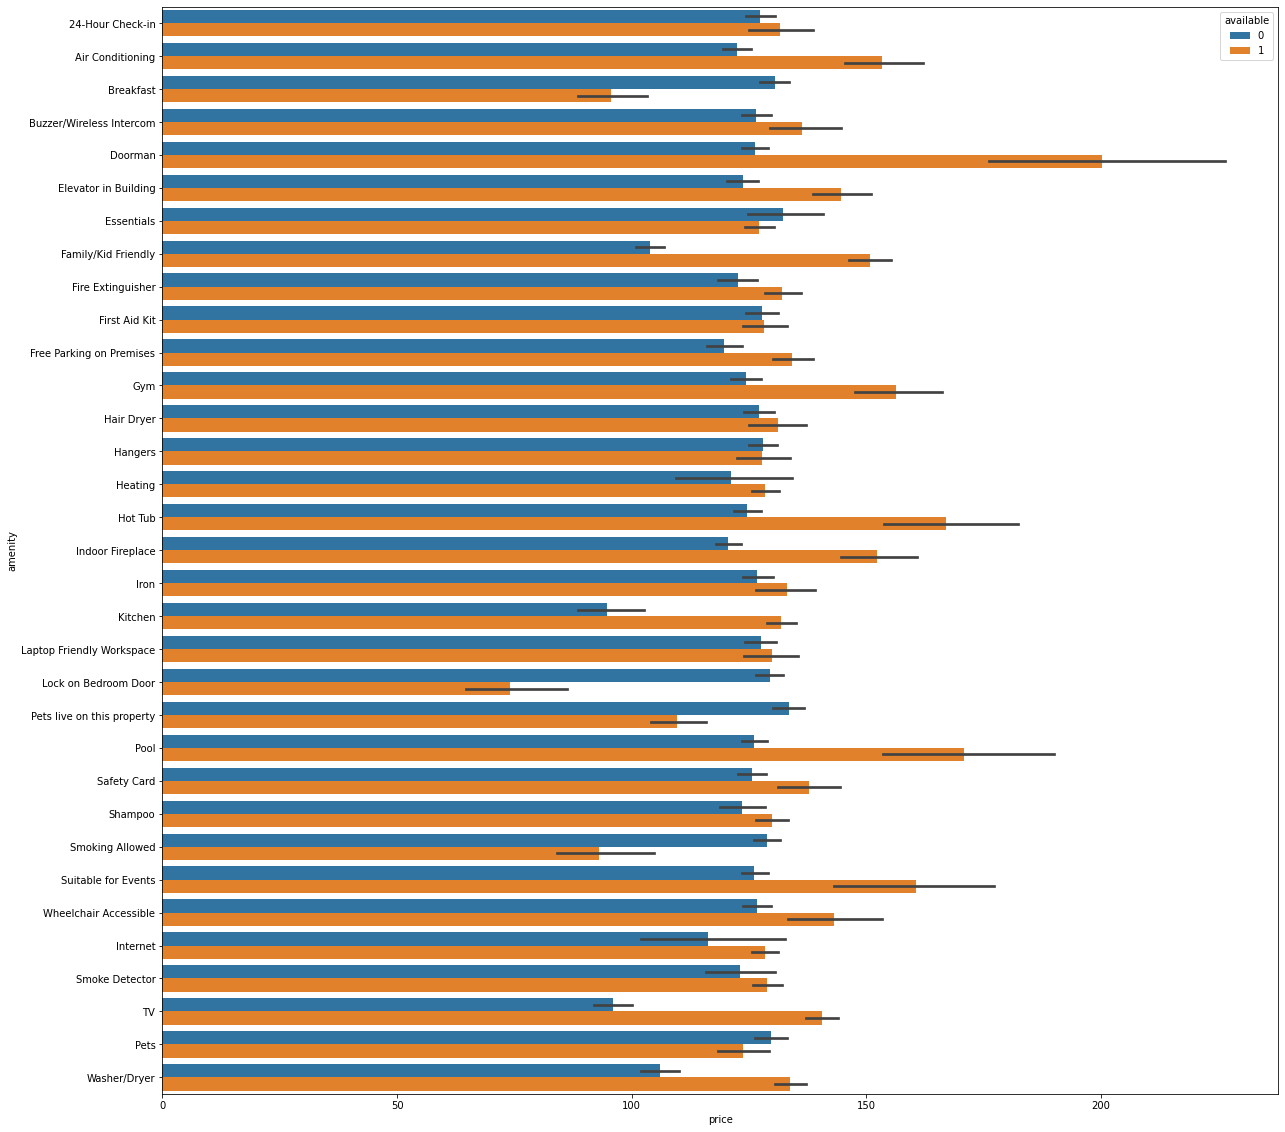

In [19]:
plt.figure(figsize=(20, 20))
sns.barplot(data=price_amenity_availability, y='amenity', x='price', hue='available')

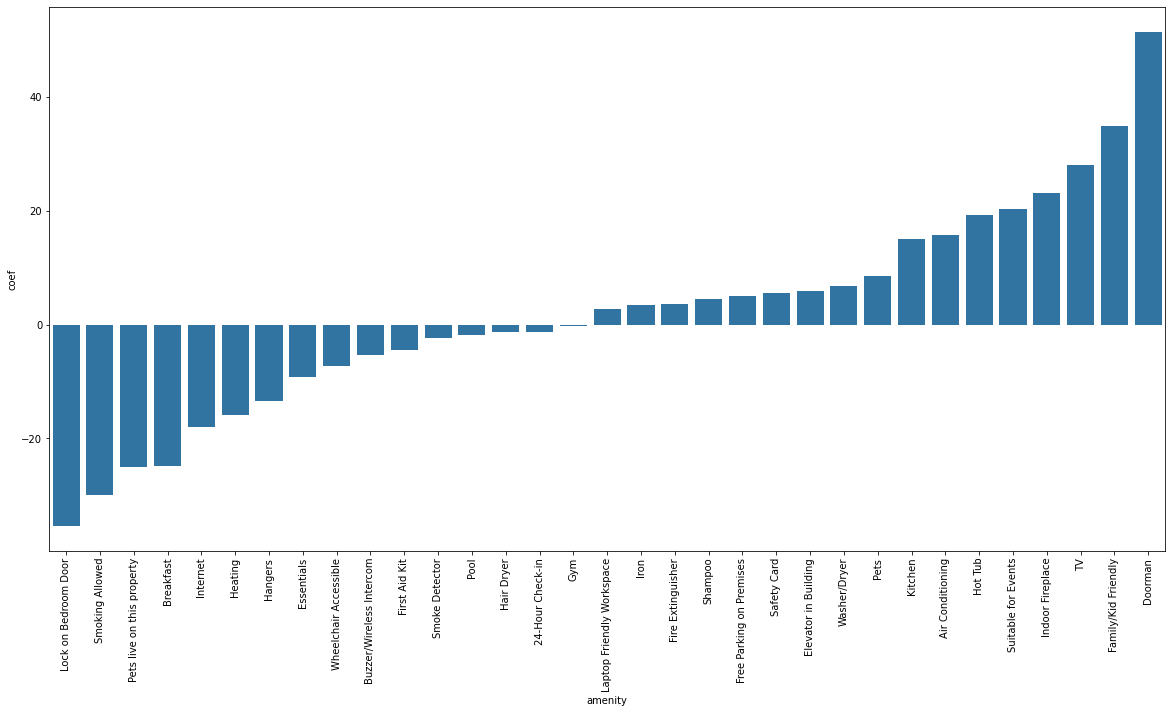

In [20]:
plt.figure(figsize=(20, 10))
sns.barplot(data=amenities_coefs, x='amenity', y='coef', color=sns.color_palette()[0])
plt.xticks(rotation=90);

## Brief explanation for visualisation

From the chart it can be seen that there is significant difference for amenities like gyms, hottubs, fireplace and pool come for only highly priced listings.

For some things, I cannot make any observation as the variation in the mean prices is high, such as for Essentials and Internet.

It is interesting to note that places that provide breakfast are priced lower than that provide breakfast. Perhaps, the high-end places charge separately for breakfast and don't offer them for free.


# Question 3: How do amenities influence the rating of the listing?


## Analyse

In [21]:
df['review_scores_rating'].isna().mean()

0.16946045049764275

In [22]:
amenities_and_review = pd.concat([amenities_cleaned, df[['review_scores_rating']]], axis=1)
amenities_and_review.dropna(inplace=True)

In [23]:
amenities_availability_rating = amenities_and_review.melt(id_vars=['review_scores_rating'])
amenities_availability_rating.columns = ['rating', 'amenity', 'availability']
amenities_availability_rating.head()

,rating,amenity,availability
0,95.0,24-Hour Check-in,0
1,96.0,24-Hour Check-in,0
2,97.0,24-Hour Check-in,0
3,92.0,24-Hour Check-in,0
4,95.0,24-Hour Check-in,0


In [24]:
X, y = amenities_and_review.drop(columns=['review_scores_rating']), amenities_and_review['review_scores_rating']
linear_model_rating = LinearRegression()
linear_model_rating.fit(X, y)
amenities_rating_coefs = pd.DataFrame({
    'amenity': X.columns,
    'coef': linear_model_rating.coef_
})
amenities_rating_coefs.sort_values('coef', inplace=True)

## Visualise

<AxesSubplot:xlabel='rating', ylabel='amenity'>

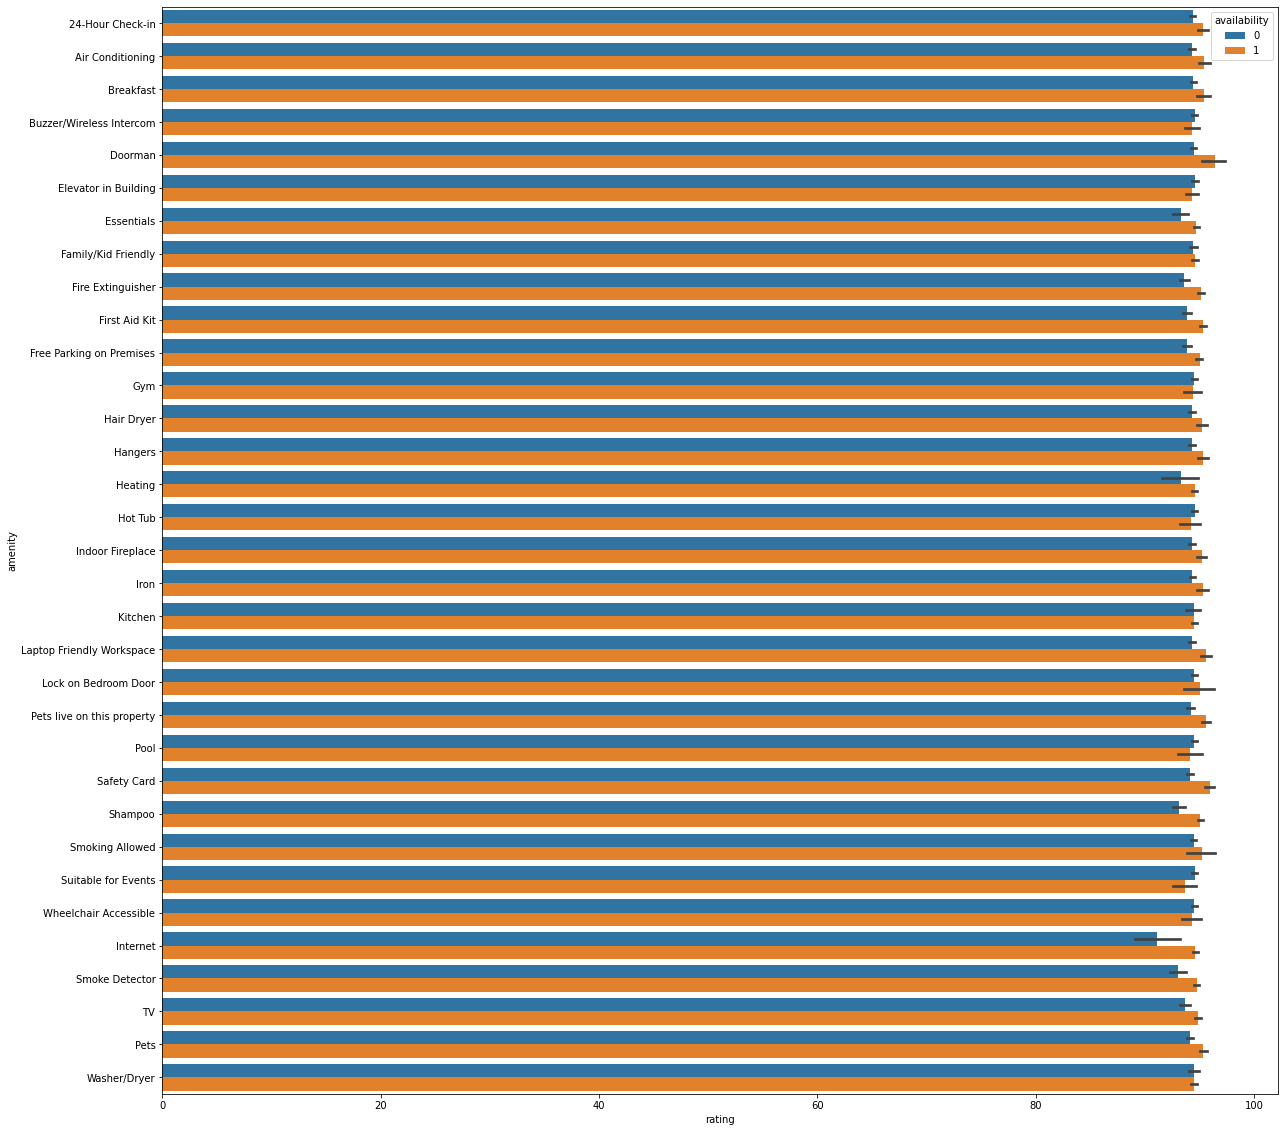

In [25]:
plt.figure(figsize=(20, 20))
sns.barplot(data=amenities_availability_rating, y='amenity', x='rating', hue='availability')

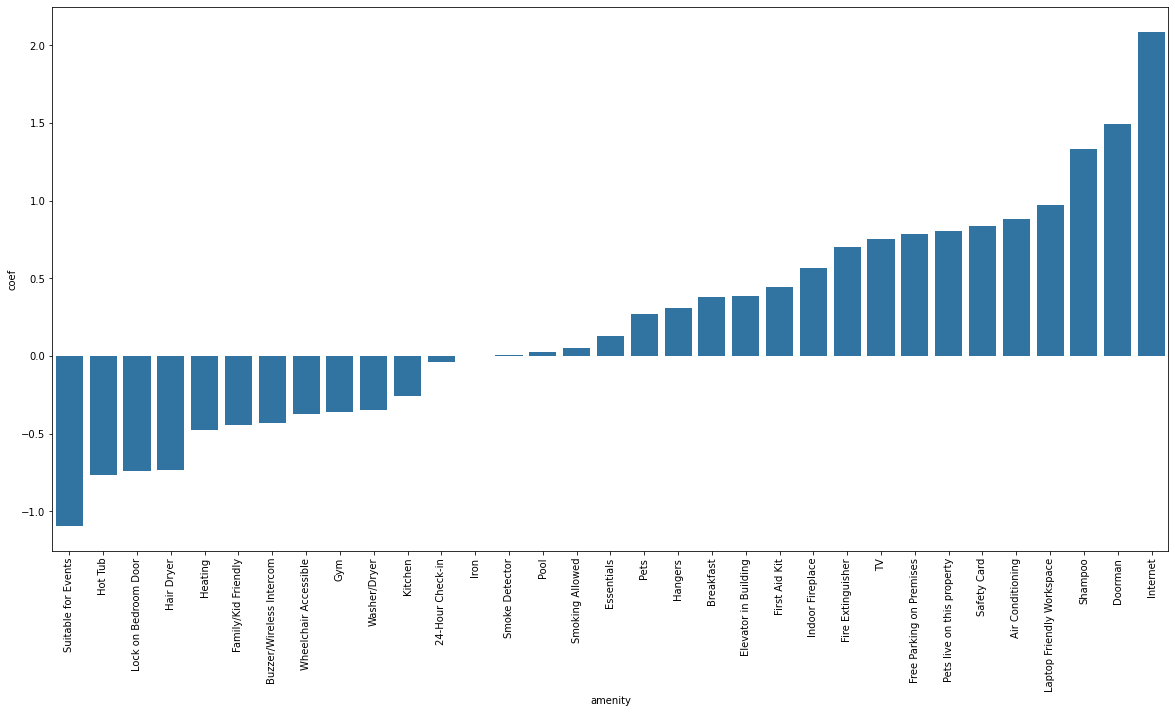

In [26]:
plt.figure(figsize=(20, 10))
sns.barplot(data=amenities_rating_coefs, y='coef', x='amenity', color=sns.color_palette()[0])
plt.xticks(rotation=90);

## Brief explanation for visualisation

Here, only Internet has a big different in how people rate the place. Absence of internet access, makes people give significantly lower ratings.

# Question 4: Which amenities ususally come together?

## Analyse

In [27]:
amenities_cleaned.corr()

,24-Hour Check-in,Air Conditioning,Breakfast,Buzzer/Wireless Intercom,Doorman,Elevator in Building,Essentials,Family/Kid Friendly,Fire Extinguisher,First Aid Kit,...,Safety Card,Shampoo,Smoking Allowed,Suitable for Events,Wheelchair Accessible,Internet,Smoke Detector,TV,Pets,Washer/Dryer
24-Hour Check-in,1.000000,0.085331,0.002817,0.100684,0.170294,0.102798,0.154104,0.104408,0.103272,0.060170,...,0.113716,0.188227,0.008694,-0.005385,0.049214,0.065084,0.068176,0.107219,-0.046574,0.090142
Air Conditioning,0.085331,1.000000,0.019126,0.143098,0.185587,0.216863,0.057317,0.083593,0.066048,0.038828,...,0.073514,0.081595,0.016367,0.039012,0.126931,0.066572,0.062519,0.169105,-0.038517,0.069458
Breakfast,0.002817,0.019126,1.000000,-0.034059,-0.016582,-0.063090,0.039250,-0.024915,0.073135,0.109276,...,0.061819,0.072108,0.120859,0.052377,0.004162,0.036487,0.026232,-0.070000,0.054488,-0.034821
Buzzer/Wireless Intercom,0.100684,0.143098,-0.034059,1.000000,0.204209,0.468247,0.056313,0.000589,-0.018947,0.024672,...,0.112272,0.117815,-0.023652,0.034912,0.253825,0.024251,0.020210,0.078223,-0.069511,0.128172
Doorman,0.170294,0.185587,-0.016582,0.204209,1.000000,0.287822,0.044159,0.033025,0.043493,0.048632,...,0.112200,0.052488,0.014382,0.049534,0.153864,0.017939,0.003770,0.070918,-0.049991,0.064334
Elevator in Building,0.102798,0.216863,-0.063090,0.468247,0.287822,1.000000,0.056757,0.030339,-0.092441,-0.104991,...,0.071844,0.057995,-0.026195,0.011477,0.376501,0.006916,0.008180,0.148962,-0.145481,0.157402
Essentials,0.154104,0.057317,0.039250,0.056313,0.044159,0.056757,1.000000,0.066700,0.200876,0.175768,...,0.140461,0.359868,-0.002624,-0.016655,0.061387,0.195220,0.337828,0.100639,-0.015204,0.085928
Family/Kid Friendly,0.104408,0.083593,-0.024915,0.000589,0.033025,0.030339,0.066700,1.000000,0.140936,0.087876,...,0.127088,0.122552,-0.000578,0.091100,0.114434,0.125502,0.115394,0.177858,0.106340,0.159007
Fire Extinguisher,0.103272,0.066048,0.073135,-0.018947,0.043493,-0.092441,0.200876,0.140936,1.000000,0.409584,...,0.318285,0.156333,0.024986,0.046096,-0.016839,0.105210,0.424145,0.086491,0.074902,0.058481
First Aid Kit,0.060170,0.038828,0.109276,0.024672,0.048632,-0.104991,0.175768,0.087876,0.409584,1.000000,...,0.376427,0.165862,0.065217,0.085907,-0.005895,0.081056,0.324131,0.058511,0.141396,0.065278


## Visualise

<AxesSubplot:>

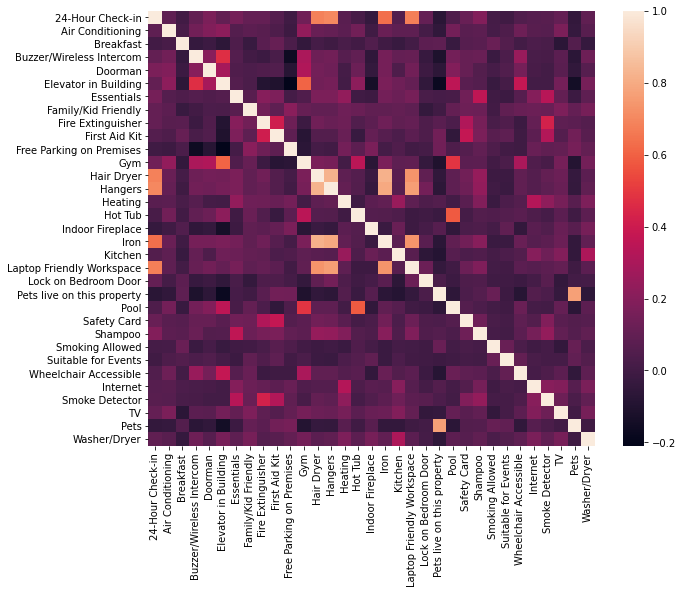

In [28]:
plt.figure(figsize=(10, 8))
sns.heatmap(amenities_cleaned.corr())

## Brief explanation for visualisation

The bright colored parts indicate that when there is ironing facility, hangers and hair dryers are also usually present. Properties that have pets living, allow hosts to bring pets.
